In [663]:
## Natalie Truong
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from IPython.display import display
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from __future__ import print_function
from sklearn.externals import joblib
import string

In [664]:
#import lists: case_number and summary
cases = open('cases_list1.txt').read().split('\n')
synopses = open('summary_list1.txt').read().split('BREAK HERE')

# synopses_clean = []

# for text in synopses:
#     text = BeautifulSoup(text, 'html.parser').getText()
#     #strips html formatting and converts to unicode
#     synopses_clean.append(text)
# synopses = synopses_clean
# Drop cases with no summary
raw = pd.DataFrame({'num': cases, 'sum': synopses})
raw = raw.drop_duplicates(subset="sum", keep=False)
cases = raw['num'].tolist()
synopses = raw['sum'].tolist()
print(str(len(cases)) + ' cases')
print(str(len(synopses)) + ' summary')

648 cases
648 summary


In [665]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(cases)):
    ranks.append(i)
    
print(len(ranks))

648


In [666]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english') + list(string.punctuation)

In [667]:
# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer("english")

In [668]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token) and token not in stopwords:
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token) and token not in stopwords:
            filtered_tokens.append(token)
    return filtered_tokens

In [669]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [670]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized, 'stem': totalvocab_stemmed}, index = totalvocab_stemmed)
vocab_frame = vocab_frame.drop_duplicates(subset ="words")
display(vocab_frame)

,words,stem
immigr,immigration,immigr
judg,judge,judg
grant,granted,grant
withhold,withholding,withhold
remov,removal,remov
salvadoran,salvadoran,salvadoran
femal,female,femal
applic,applicant,applic
fled,fled,fled
gang,gang,gang


In [671]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.50, max_features=200000,
                                 min_df=0.05, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem)

tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

/Users/nguyenbaotruong/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


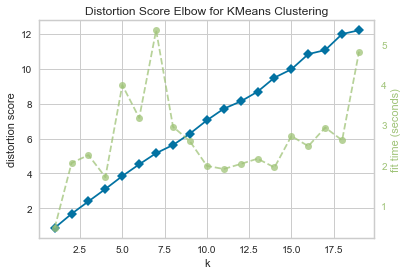

In [672]:
# ELBOW METHOD TO FIND GOOD K

from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
# Run the Kmeans algorithm and get the index of data points clusters
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 20))
visualizer.fit(tfidf_matrix)    # Fit the data to the visualizer
visualizer.poof()   

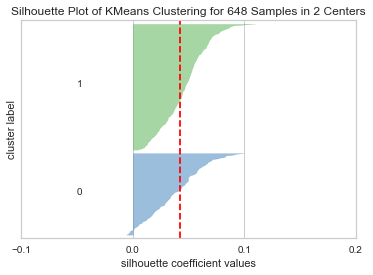

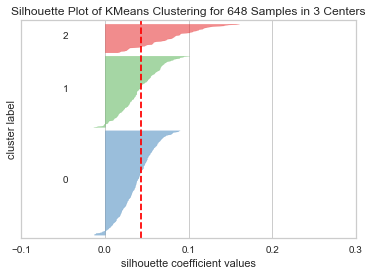

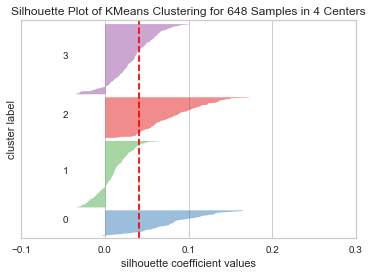

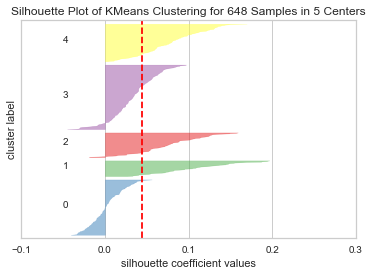

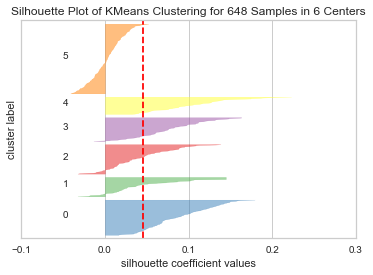

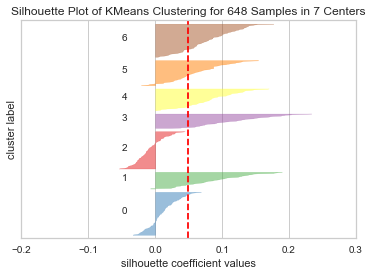

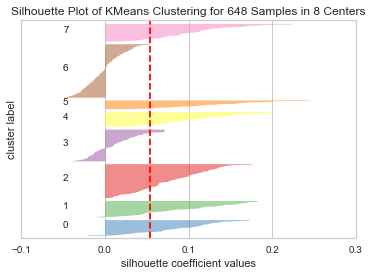

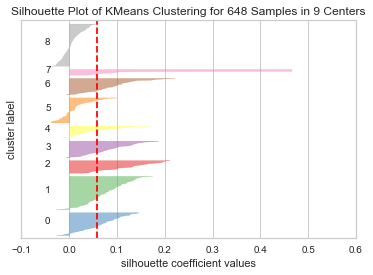

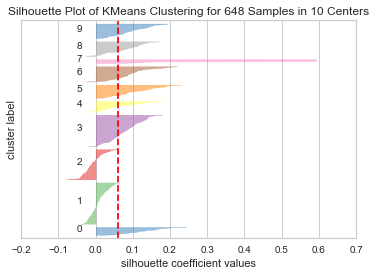

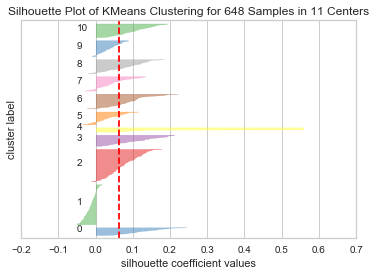

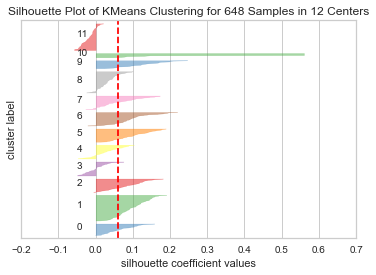

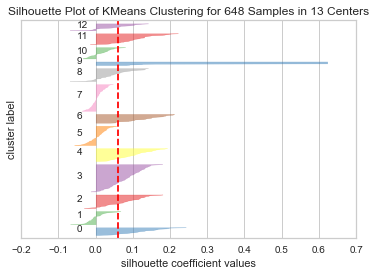

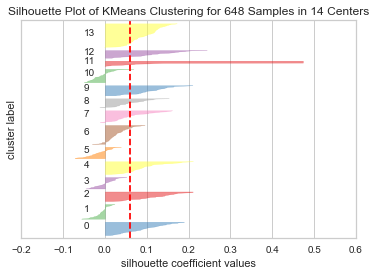

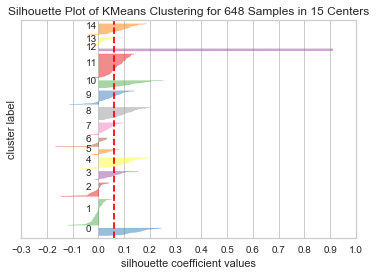

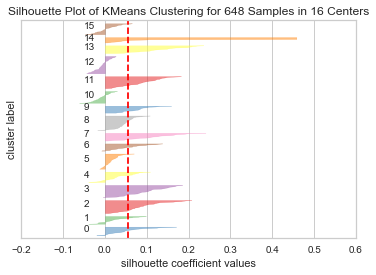

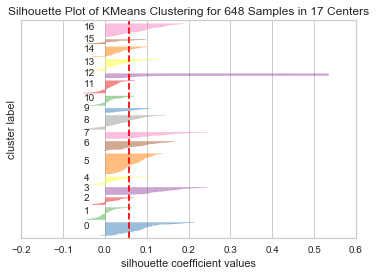

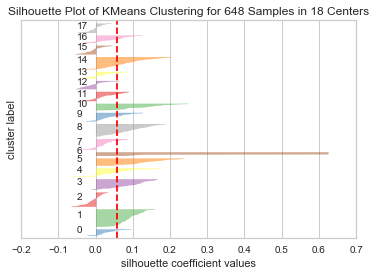

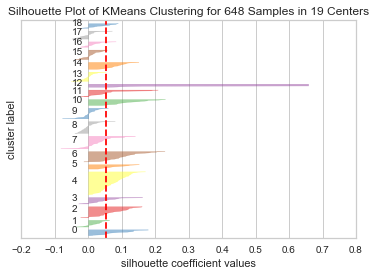

In [673]:
# SILHOUETTE ANALYSIS TO JUSTIFY HOW FAR THE CLUSTERS ARE FROM EACH OTHER
from yellowbrick.cluster import SilhouetteVisualizer

for i in range(2, 20):
    # Instantiate the clustering model and visualizer
    model = KMeans(i)
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(tfidf_matrix) # Fit the training data to the visualizer
    visualizer.poof() # Draw/show/poof the data

In [674]:
terms = tfidf_vectorizer.get_feature_names()
print("terms", terms)
print("terms length", len(terms))

terms ["'s", 'abl', 'abus', 'accord', 'activ', 'afraid', 'age', 'allow', 'anoth', 'arm', 'armi', 'arrang', 'arrest', 'ask', 'attack', 'attempt', 'attend', 'attorney', 'author', 'away', 'base', 'beat', 'beaten', 'becam', 'began', 'believ', 'birth', 'born', 'brother', 'came', 'case', 'child', 'children', 'citizen', 'claim', 'come', 'continu', 'control', 'countri', 'cousin', 'cut', 'daughter', 'day', 'death', 'decid', 'demand', 'deni', 'die', 'divorc', 'domest', 'educ', 'el', 'emot', 'escap', 'eventu', 'experienc', 'face', 'famili', 'father', 'fear', 'femal', 'fgc', 'fgm', 'file', 'fled', 'follow', 'forc', 'friend', 'gang', 'gave', 'girl', 'govern', 'group', 'guatemala', 'guatemalan', 'hand', 'harass', 'harm', 'head', 'held', 'help', 'high', 'home', 'honduran', 'hospit', 'hous', 'howev', 'husband', 'ij', 'immigr', 'incid', 'includ', 'involv', 'islam', 'job', 'join', 'judg', 'kidnap', 'kill', 'knew', 'know', 'later', 'law', 'learn', 'leav', 'left', 'life', 'live', 'look', 'make', 'male', '

In [675]:
dist = 1 - cosine_similarity(tfidf_matrix)

In [688]:
num_clusters = 8
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [689]:
joblib.dump(km, 'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [690]:
case_collection = { 'number': cases, 'rank': ranks, 'summary': synopses, 'cluster': clusters }

frame = pd.DataFrame(case_collection, index = [clusters] , columns = ['rank', 'number', 'cluster', 'summary'])
display(frame)

,rank,number,cluster,summary
4,0,Case #17640,4,The immigration judge granted withholding of r...
0,1,Case #18861,0,\nThe asylum office granted asylum to a Salvad...
4,2,Case #10813,4,\nUnaccompanied Salvadoran minor who cooperate...
4,3,Case #10814,4,\nApplicant is an unaccompanied Salvadoran min...
0,4,Case #10812,0,\nMexican woman who was raped and impregnated ...
6,5,Case #2994,6,\nIJ granted asylum on December 2007. Followin...
3,6,Case #10811,3,\nGuatemalan woman who survived childhood sexu...
0,7,Case #10744,0,\nThe San Francisco Asylum Office granted asyl...
0,8,Case #10743,0,\nMexican woman who had suffered years of ince...
0,9,Case #10810,0,"\nClient is a gay, Mexican man who repressed h..."


In [691]:
frame['cluster'].value_counts()

5    155
3    116
0     78
6     74
1     69
7     55
4     52
2     49
Name: cluster, dtype: int64

In [692]:
grouped = frame['rank'].groupby(frame['cluster'])
grouped.mean()

cluster
0    417.192308
1    383.840580
2    433.489796
3    243.206897
4    430.961538
5    265.374194
6    246.662162
7    351.872727
Name: rank, dtype: float64

In [693]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame['words'].ix[terms[ind].split(' ')].values.tolist()[0], end=',')
    print()
    print()
    print("Cluster %d cases:" % i, end='')
    for title in frame.ix[i]['number'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: office, abuse, sexual, minor, guatemalan, physically,

Cluster 0 cases: Case #18861, Case #10812, Case #10744, Case #10743, Case #10810, Case #10707, Case #10827, Case #3309, Case #3579, Case #3182, Case #4123, Case #4115, Case #2753, Case #1004, Case #1221, Case #1124, Case #268, Case #898, Case #6620, Case #10922, Case #11435, Case #8227, Case #4270, Case #4894, Case #7922, Case #18069, Case #4923, Case #12436, Case #11257, Case #4893, Case #5390, Case #12189, Case #22358, Case #11272, Case #10615, Case #11009, Case #8672, Case #4892, Case #6322, Case #11071, Case #10617, Case #6687, Case #3877, Case #10008, Case #8653, Case #22570, Case #4943, Case #5701, Case #11752, Case #10065, Case #4942, Case #11083, Case #7083, Case #25669, Case #5697, Case #20655, Case #11772, Case #10771, Case #6903, Case #19200, Case #11345, Case #5651, Case #10640, Case #10688, Case #4940, Case #10371, Case #10644, Case #20828, Case #380, Case #6502, Case #22895, Ca

/Users/nguyenbaotruong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/Users/nguyenbaotruong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


In [694]:
#This is purely to help export tables to html and to correct for my 0 start rank
frame['Rank'] = frame['rank'] + 1
frame['Case Number'] = frame['number']

In [695]:
#set up colors per clusters using a dict
cluster_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 
                 1: 'Cluster 2', 
                 2: 'Cluster 3', 
                 3: 'Cluster 4', 
                 4: 'Cluster 5',
                 5: 'Cluster 6',
                6: 'Cluster 7',
                7: 'Cluster 8',
                8: 'Cluster 9',
                9: 'Cluster 10',
                10: 'Cluster 11',
                11: 'Cluster 12',
                12: 'Cluster 13',
                13: 'Cluster 14',
                14: 'Cluster 15',
                15: 'Cluster 16',
                16: 'Cluster 17',
                17: 'Cluster 18',
                18: 'Cluster 19',
                19: 'Cluster 20',}

In [696]:
MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [697]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [698]:
%matplotlib inline

/Users/nguyenbaotruong/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


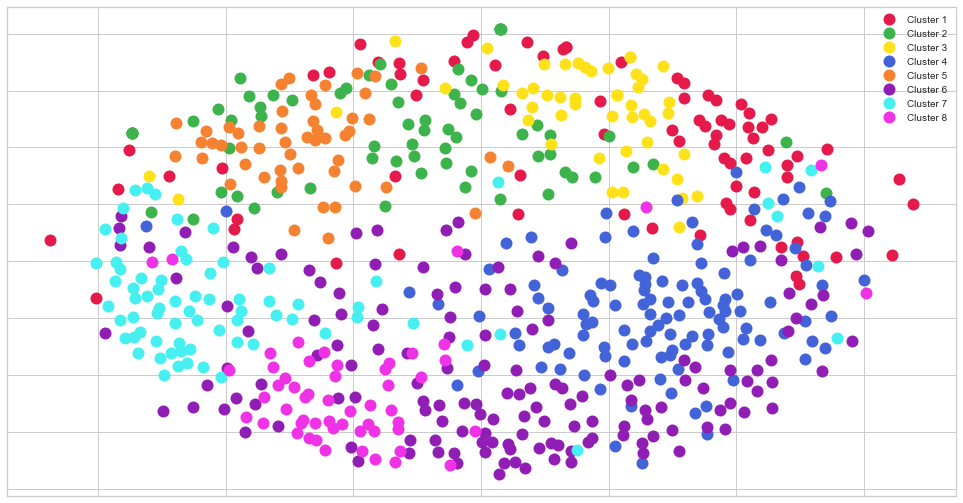

In [699]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=cases)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

# #add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)